[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  4 of 4 completed
Nani?! in data
Something didn't match!
Something didn't match!
Something didn't match!
Something didn't match!
Something didn't match!
Something didn't match!
Something didn't match!
Something didn't match!
Something didn't match!
[[0.14726591 0.00740369 0.28348061 0.90560406]
 [0.16287018 0.00718103 0.23738952 0.93958657]
 [0.15941873 0.00679135 0.2424201  0.91673288]
 ...
 [0.75404546 0.86439547 0.17675049 0.75198726]
 [0.77007934 0.87085282 0.16723317 0.74721776]
 [0.76770556 0.87096412 0.17036029 0.75616054]]


array([[0.12487773],
       [0.12017388],
       [0.12474665],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

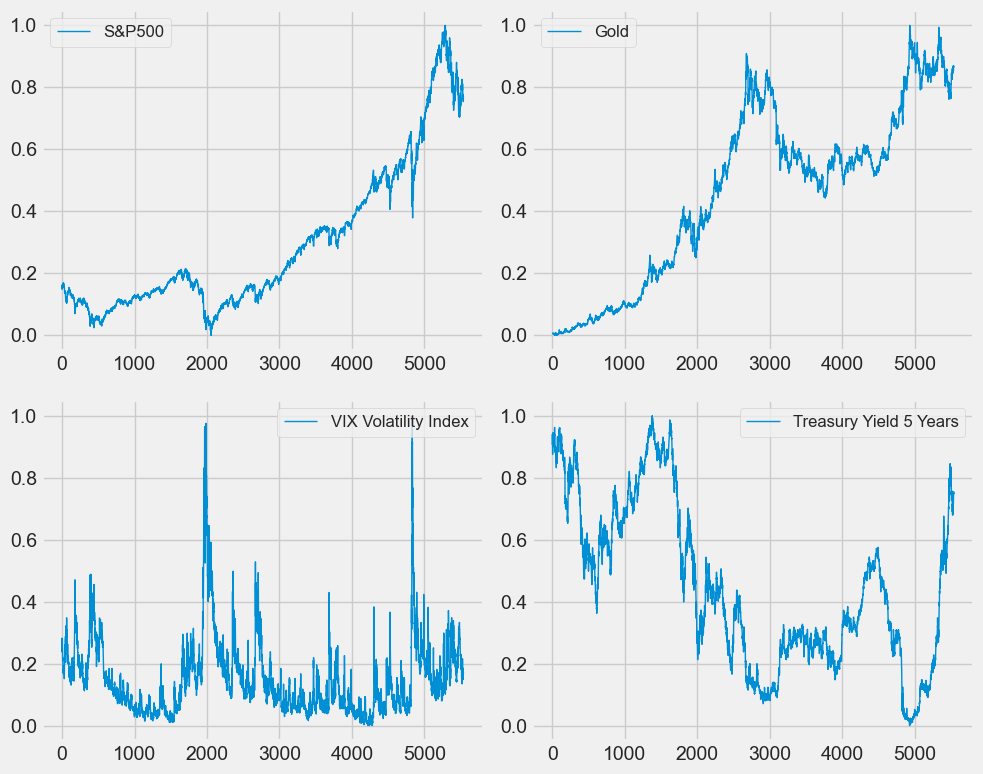

In [1]:
import sys
sys.path.insert(1, r"C:/Users/mihao/OneDrive - Univerza v Ljubljani/Doktorski_studij/Delo/Evolving transformer")
sys.path.insert(1, r"C:\Users\Miha\OneDrive - Univerza v Ljubljani\Doktorski_studij\Delo\Evolving transformer")
from importlib import reload 
import data.dataclass as dataclass
reload(dataclass)

input_length = 128
output_length = 1
output_steps_ahead = 10
database = dataclass.StockData(input_length,output_length,output_steps_ahead)
database.display_data_norm()

#print(database.data_dropped)
print(database.data_norm)

#print(database.datasnp_dropped)
scalar = database.scalar

database.dataset_input
database.dataset_output


In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class Stockdataset(Dataset):
    def __init__(self, data, input_length = 128, output_length = 1):
        self.data = data
        self.data = torch.from_numpy(data).float()#.view(-1)
        self.seq_len = input_length
        self.out_len = output_length

    def __len__(self):
        return len(self.data)-(self.seq_len+self.out_len+1)

    def __getitem__(self, index):
        return self.data[index : index+self.seq_len], self.data[index+self.seq_len+1: index+self.seq_len+self.out_len+1,0]
        
size_training = int(len(database.data_norm)*0.8)
size_test = len(database.data_norm) - size_training
data_train, data_test = database.data_norm[0:size_training,:], database.data_norm[size_training:len(database.data_norm),:]

print(data_train.shape)
print(data_test.shape)

train_dataset = Stockdataset(data_train, input_length, output_length)
test_dataset = Stockdataset(data_test, input_length, output_length)
whole_dataset = Stockdataset(database.data_norm, input_length, output_length)

print(test_dataset.__getitem__(1)[0].shape)
print(train_dataset.__getitem__(1)[1].shape)
print(whole_dataset.__getitem__(0)[0].shape)


c:\Users\mihao\Anaconda3\envs\evolver\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(4431, 4)
(1108, 4)
torch.Size([128, 4])
torch.Size([1])
torch.Size([128, 4])


In [3]:
batch_size = 257
train_dataloader = DataLoader(train_dataset, batch_size, drop_last = True, shuffle=True) #drop_last = True ignores last batch is data is not divisable by batch_size
test_dataloader = DataLoader(test_dataset, batch_size, drop_last = True, shuffle=True)
whole_dataloader = DataLoader(whole_dataset, 1, drop_last = False)
whole_dataloader = DataLoader(train_dataset, 1, drop_last = False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [4]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = 0.1*torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=(torch.randn(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
            	20*torch.diag_embed(torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        self.msa = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.fc_ant = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.fc_con = nn.Linear(self.cluster_dim, output_length) #output_length
        self.sm = torch.nn.Softmax(dim = 1)
        self.fc_emb = nn.Linear(input_length, 3*self.embed_dim) #output_length
        self.input_layer_norm = nn.LayerNorm(input_length)
        self.ant_norm = nn.LayerNorm(self.cluster_dim)
        #self.evol_drop_layer = nn.Dropout(p=0.5)

    def forward(self, x, u):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size,1,input_length)

        #x = self.input_layer_norm(x)
        self.x_emb = self.fc_emb(x)
        query,key,value = self.x_emb.chunk(3, dim=-1)
        self.x_att, _ = self.msa(query,key,value)
        #self.x_att = self.input_layer_norm(self.x_att)
        self.x_ant = self.fc_ant(self.x_att)
        #self.x_ant = self.ant_norm(self.x_ant)

        x_con = self.x_ant

        #self.x_ant = self.input_layer_norm(self.x_ant)
        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)

        d = torch.sub(self.mu, self.x_ant)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1))
        #sigma_inv = self.sigma_inv
        
        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        d2 = torch.matmul(d2_dS, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2))
        psi = self.sm(-d2).reshape(batch_size, 1, self.num_clusters)
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        
        x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con) #.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        
        #print(torch.sum(psi[0]))
        y = torch.matmul(psi, y_con)
        
        #final_out = self.fc(out)
        return y

Parameter containing:
tensor([-0.0421], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-8.3243e-02, -8.7455e-05,  6.0094e-02,  3.3623e-02, -8.6246e-02,
         -5.1742e-02, -3.4456e-02, -3.2237e-02,  6.2014e-02,  4.4352e-02,
         -6.6050e-02, -8.6940e-02, -7.5306e-02, -1.5607e-02,  2.2830e-02,
         -9.3741e-03,  9.8533e-03,  4.4288e-02,  2.7322e-02,  8.4762e-02,
         -5.4922e-02, -1.4254e-03,  3.6186e-02,  7.3367e-02,  6.2559e-02,
          8.7746e-02,  3.3499e-02, -2.8155e-02,  4.1667e-02, -1.1608e-02,
         -4.8988e-02, -3.4460e-02,  2.7026e-02, -1.0782e-02, -7.0856e-02,
          3.4015e-02, -5.2959e-02, -5.3750e-02, -1.5489e-04, -4.6701e-02,
         -4.0854e-02, -8.6739e-02, -5.1759e-02,  4.7273e-02,  6.9718e-02,
          2.8140e-02, -8.0240e-02,  7.1895e-02,  6.9584e-02, -9.8424e-03,
         -4.6106e-02,  4.1056e-02, -2.0203e-02, -3.2416e-02, -1.2959e-02,
         -6.2697e-03,  6.3665e-02, -3.3460e-02,  7.4706e-02, -3.8094e-02,
          4.6

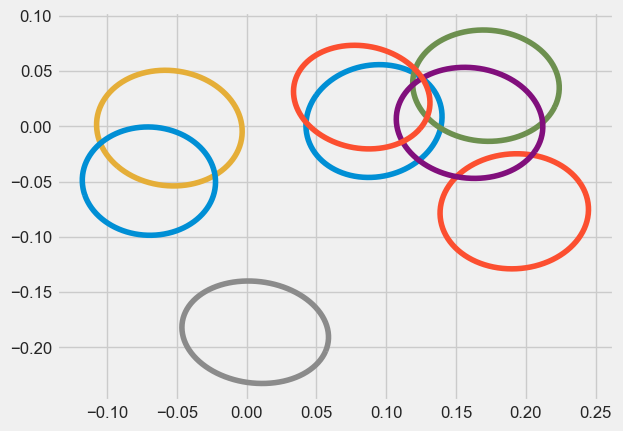

In [5]:
class Lstm_model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.output_size = output_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_size, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.evolve = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads)
        #self.fc = EvolvingSystem(input_dim, output_dim, cluster_dim, num_clusters,hidden_size)

    def forward(self, x, hn, cn):
        out, (hn, cn) = self.lstm(x, (hn,cn))
        out = self.fc(out)
        final_out = self.evolve(out,x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn
    
    '''
    def predict(self, x):
        hn, cn = self.init()
        out = self.fc(out)
        final_out = self.evolve(out, x[-1,:,0])
        #final_out = self.fc(out)
        return final_out, hn, cn 
    '''
    
    def init(self):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device) #zakaj je batch_size tako?
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return h0,c0

embed_dim = input_length
num_heads = input_length//8
cluster_dim = 3
num_clusters = 8
input_dim = 4
output_dim = 1
hidden_size = input_length//32
num_layers = 2
model = Lstm_model(input_dim, output_dim, hidden_size, num_layers).to(device)

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())[:,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()[:,0:2]
ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1]) 
display.display(pl.gcf())   
display.clear_output(wait=True)
time.sleep(0.1)

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)



In [6]:
def train(dataloader):
    hn, cn = model.init()
    model.train()
    loss_sum = 0
    x_ant = np.empty((0,1,cluster_dim))     
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        #out, hn, cn = model(x, hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
        hn = hn.detach() #detach hn is not a parameters and does not need to be updated!!!
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Train loss: {loss_sum:>7f}")
    return loss_sum, x_ant

In [7]:
def test(dataloader):
    hn, cn = model.init()
    loss_sum = 0
    for batch, item in enumerate(dataloader):
        x, y = item
        x = x.to(device)
        y = y.to(device)
        out, hn, cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)
        loss = loss_fun(out.reshape(batch_size, output_dim,-1), y.reshape(batch_size, output_dim,-1))
        loss_sum = loss_sum + loss.item()
        if batch == len(dataloader) -1:
            #loss = loss.item()
            print(f"Test loss: {loss_sum:>7f}")   
    return loss_sum
            

In [8]:
'''
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv
import time
import pylab as pl
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns

class EvolvingSystem(nn.Module):
    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads):
        super(EvolvingSystem, self).__init__()
        self.input_size = input_dim
        self.output_size = output_dim
        self.cluster_dim = cluster_dim
        self.num_clusters = num_clusters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)
        self.mu = torch.nn.Parameter(data = 0.1*torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.sigma_inv = torch.nn.Parameter(data=(torch.randn(self.num_clusters,self.cluster_dim, self.cluster_dim)  + 
            	20*torch.diag_embed(torch.ones(self.num_clusters,self.cluster_dim))), requires_grad=True)
        self.msa = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        #self.sigma = torch.nn.Parameter(torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1)), requires_grad=True)
        #self.sigma_alpha = torch.nn.Parameter(data=torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)
        self.fc_ant = nn.Linear(input_length, self.cluster_dim) #self.cluster_dim
        self.fc_con = nn.Linear(input_length, output_length) #output_length
        self.sm = torch.nn.Softmax(dim = 1)
        #self.fc_emb = nn.Linear(input_length, 3*self.embed_dim) #output_length
        self.input_layer_norm = nn.LayerNorm(input_length)
        self.ant_norm = nn.LayerNorm(self.cluster_dim)
        self.evol_drop_layer = nn.Dropout(p=0.1)

    def forward(self, x, u):
        #torch.Size([256, 128, 16]); IxBxH
        #self.x = x.flatten()
        x = x.reshape(batch_size,1,input_length)
        x_con = x.reshape(batch_size, 1, input_length)
        
        #x = self.input_layer_norm(x)
        #self.x_emb = self.fc_emb(x)
        #query,key,value = self.x_emb.chunk(3, dim=-1)
        self.x_att, _ = self.msa(x, x, x)
        #self.x_att = self.input_layer_norm(self.x_att)
        self.x_ant = self.fc_ant(self.x_att)
        #self.x_ant = self.ant_norm(self.x_ant)
        
        #self.x_ant = self.input_layer_norm(self.x_ant)
        #self.x_ant = torch.cat((self.x_ant, u.reshape(batch_size,1,1)), dim = 2)

        d = torch.sub(self.mu, self.x_ant)
        dl = d.reshape(batch_size, self.num_clusters, 1, self.cluster_dim)
        
        #TEST OK -> self.mu-self.x_ant[0][0], d[0], dl[0]
        sigma_inv = torch.matmul(self.sigma_inv, torch.transpose(self.sigma_inv, 2, 1))
        #sigma_inv = self.sigma_inv
        
        d2_dS = torch.matmul(dl, sigma_inv)

        dr = d.reshape(batch_size, self.num_clusters, self.cluster_dim, 1)

        d2 = torch.matmul(d2_dS, dr)
        #d2 = torch.pow(d2, torch.pow(self.etta, 2))
        psi = self.sm(-d2).reshape(batch_size, 1, self.num_clusters)
        #psi = self.evol_drop_layer(psi)
        #TEST OK -> self.sm(-d2).reshape(batch_size,1,self.num_clusters)[0], self.sm(-d2)
        
        x_con = x_con.repeat(1,self.num_clusters,1)
        y_con = self.fc_con(x_con) #.reshape(batch_size, -1, self.num_clusters) #.reshape(batch_size, output_length, self.num_clusters)
        
        #print(torch.sum(psi[0]))
        y = torch.matmul(psi, y_con)
        
        #final_out = self.fc(out)
        return y
        '''

'\nfrom importlib import reload \nimport compute_ellipse\nreload(compute_ellipse)\nfrom numpy.linalg import inv\nimport time\nimport pylab as pl\nfrom IPython import display\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\nclass EvolvingSystem(nn.Module):\n    def __init__(self, input_dim, output_dim, cluster_dim, num_clusters,embed_dim,num_heads):\n        super(EvolvingSystem, self).__init__()\n        self.input_size = input_dim\n        self.output_size = output_dim\n        self.cluster_dim = cluster_dim\n        self.num_clusters = num_clusters\n        self.embed_dim = embed_dim\n        self.num_heads = num_heads\n        #self.etta = torch.nn.Parameter(data=torch.ones(1), requires_grad=True)\n        self.mu = torch.nn.Parameter(data = 0.1*torch.randn(self.num_clusters,self.cluster_dim), requires_grad=True)\n        self.sigma_inv = torch.nn.Parameter(data=(torch.randn(self.num_clusters,self.cluster_dim, self.cluster_dim)  + \n            \t20*torch.diag_embed(torch.

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[-0.0583,  0.2518, -0.3528,  0.2511],
        [-0.0869,  0.0728,  0.0396,  0.2847],
        [ 0.1197,  0.3440, -0.3842, -0.4568],
        [ 0.0473,  0.1670, -0.2292,  0.4536],
        [ 0.3221, -0.1916,  0.3471,  0.2564],
        [-0.0357, -0.0510,  0.4109, -0.3686],
        [-0.2225,  0.1677,  0.4407,  0.3928],
        [ 0.3875, -0.1820, -0.2076,  0.3314],
        [ 0.0335, -0.1962, -0.0191, -0.4832],
        [-0.2581,  0.0910,  0.3045,  0.1042],
        [-0.4770, -0.4833, -0.1270, -0.2668],
        [ 0.3325,  0.4631,  0.1709, -0.2776],
        [ 0.1840,  0.2389, -0.1215, -0.4067],
        [-0.2600, -0.1694,  0.3000,  0.3837],
        [-0.0869,  0.3212,  0.2607, -0.0260],
        [-0.3896,  0.2646, -0.2404,  0.4513]], device='cuda:0')
lstm.weight_hh_l0 tensor([[-0.1166, -0.3525, -0.1109, -0.3327],
        [ 0.1286, -0.4565, -0.2489, -0.2370],
        [ 0.1311, -0.2080,  0.1626,  0.1933],
        [ 0.3497, -0.0227,  0.4863,  0.2370],
        [-0.4069, -0.2064,

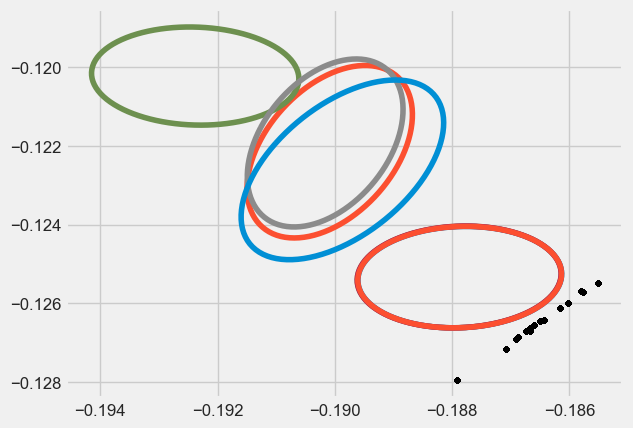

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

batch_size = 257
best_model = 1
loss_fun = nn.MSELoss()
gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', init_params="kmeans")

train_iterations = 50
for i in range(train_iterations):
    lr = 1e-3
    for p in model.parameters():
        p.requires_grad = True
    for name, param  in model.named_parameters():
        print(name)
        if "evolve.fc_con.weight" == name:
            param.requires_grad = False
        if "evolve.fc_con.bias" == name:
            param.requires_grad = False
        if "evolve.fc_emb.weight" == name:
            param.requires_grad = False
        if "evolve.fc_emb.bias" == name:
            param.requires_grad = False
            
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    
    epochs = 2
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        loss_train, x_ant_train = train(train_dataloader)
        loss_test = test(test_dataloader)
        state_dict = model.state_dict()
        if (best_model > loss_train):
            best_model = loss_train
            torch.save(state_dict, "model_evolve.pt")
            
        #state_dict['model.evolve.mu'] = torch.from_numpy(gmm.means_)
        #state_dict['model.evolve.sigma_inv'] = torch.from_numpy(inv(gmm.covariances_))
        #model.load_state_dict(state_dict)
        #sns.heatmap(model.x_ant.detach().cpu().numpy()[0,:,:], vmin=0, vmax=1.0, cmap="OrRd")
        #plt.plot(model.evolve.x_ant.detach().cpu().numpy()[0,0,:])
        if True:
            display.clear_output(wait=True) 
            sigma_inv = model.evolve.sigma_inv
            sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
            sigma = inv(sigma_inv.detach().cpu().numpy())
            nc_plot = num_clusters
            sigma = sigma[0:nc_plot,0:2,0:2]
            mu = model.evolve.mu.detach().cpu().numpy()
            mu = mu[0:nc_plot,0:2]
            ellipse = compute_ellipse.Ellipse(sigma,mu,1)
            ellipse_points = ellipse.confidence_ellipse()
            ellipse_points = np.einsum('ijk->jik', ellipse_points)
            plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
            plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
            plt.show()
            display.display(pl.gcf()) 
    
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='full', init_params="kmeans")
    #gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sigma)).transpose((0, 2, 1))
    gmm.fit(x_ant_train[:,0,:])
    mu = gmm.means_
    sigma_inv = (gmm.covariances_)
    u, s, v   = np.linalg.svd(sigma_inv, full_matrices=True)
    s_sqrt = torch.diag_embed(torch.from_numpy(np.sqrt(s))).numpy()
    sigma_inv = inv(np.matmul(s_sqrt, v))
    
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'evolve.mu' == name:
                param.copy_(torch.from_numpy(mu))
            if 'evolve.sigma_inv' == name:
                param.copy_(torch.from_numpy(sigma_inv))
     
    for p in model.parameters():
        p.requires_grad = False
    for name, param  in model.named_parameters():
        print(name)
        if "evolve.fc_con.weight" == name:
            param.requires_grad = True
        if "evolve.fc_con.bias" == name:
            param.requires_grad = True
    
    if True:
        display.clear_output(wait=True) 
        sigma_inv = model.evolve.sigma_inv
        sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
        sigma = inv(sigma_inv.detach().cpu().numpy())
        nc_plot = num_clusters
        sigma = sigma[0:nc_plot,0:2,0:2]
        mu = model.evolve.mu.detach().cpu().numpy()
        mu = mu[0:nc_plot,0:2]
        ellipse = compute_ellipse.Ellipse(sigma,mu,1)
        ellipse_points = ellipse.confidence_ellipse()
        ellipse_points = np.einsum('ijk->jik', ellipse_points)
        plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
        plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
        plt.show()
        display.display(pl.gcf())   
        
        
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    epochs = 2
    for epoch in range(epochs):
        print(f"Epoch {epoch}")
        loss_train, x_ant_train = train(train_dataloader)
        loss_test = test(test_dataloader)
        state_dict = model.state_dict()
        if (best_model > loss_train):
            best_model = loss_train
            torch.save(state_dict, "model_evolve.pt")
            
        #state_dict['model.evolve.mu'] = torch.from_numpy(gmm.means_)
        #state_dict['model.evolve.sigma_inv'] = torch.from_numpy(inv(gmm.covariances_))
        #model.load_state_dict(state_dict)
        #sns.heatmap(model.x_ant.detach().cpu().numpy()[0,:,:], vmin=0, vmax=1.0, cmap="OrRd")
        #plt.plot(model.evolve.x_ant.detach().cpu().numpy()[0,0,:])
        if True:
            display.clear_output(wait=True) 
            sigma_inv = model.evolve.sigma_inv
            sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
            sigma = inv(sigma_inv.detach().cpu().numpy())
            nc_plot = num_clusters
            sigma = sigma[0:nc_plot,0:2,0:2]
            mu = model.evolve.mu.detach().cpu().numpy()
            mu = mu[0:nc_plot,0:2]
            ellipse = compute_ellipse.Ellipse(sigma,mu,1)
            ellipse_points = ellipse.confidence_ellipse()
            ellipse_points = np.einsum('ijk->jik', ellipse_points)
            plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.k')
            plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
            plt.show()
            display.display(pl.gcf())   
        

            


In [11]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            x = x.view(input_length, batch_size, input_dim)
            pred = model(x, hn, cn)
            pred = pred.view(batch_size, -1,1)
            pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=2)
            pred = scalar.inverse_transform(pred)[:,0]
            y = np.repeat(y.detach().cpu().numpy(),input_dim,axis=1)
            y = scalar.inverse_transform(y)[:,0]
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        return math.sqrt(mean_squared_error(y_arr,pred_arr))



In [12]:
from torchsummary import summary

print(model.evolve.fc_con.bias)
print(model.evolve.fc_con.weight)
#print(model.evolve.sigma_inv)
#print(model.evolve.mu)

#summary(model,[(input_length, 1, input_dim),(num_layers, 1, hidden_size),(num_layers, 1, hidden_size)])

model.load_state_dict(torch.load("model_evolve.pt"))
model.eval()


Parameter containing:
tensor([0.0307], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0807,  0.1105,  0.1486,  0.1144, -0.0098,  0.0208,  0.0354,  0.0351,
          0.1273,  0.1083, -0.0032, -0.0255, -0.0151,  0.0431,  0.0797,  0.0462,
          0.0640,  0.0970,  0.0787,  0.1352, -0.0053,  0.0471,  0.0842,  0.1206,
          0.1092,  0.1341,  0.0798,  0.0185,  0.0884,  0.0355, -0.0018,  0.0127,
          0.0743,  0.0361, -0.0245,  0.0796, -0.0077, -0.0094,  0.0430, -0.0046,
          0.0002, -0.0463, -0.0119,  0.0861,  0.1079,  0.0657, -0.0428,  0.1090,
          0.1064,  0.0272, -0.0085,  0.0788,  0.0177,  0.0050,  0.0241,  0.0304,
          0.1001,  0.0029,  0.1109, -0.0016,  0.0835,  0.0236, -0.0283,  0.0981,
          0.0535, -0.0077, -0.0345,  0.0789,  0.1105,  0.1011,  0.0705, -0.0327,
         -0.0355, -0.0483, -0.0421,  0.1198,  0.0444,  0.0942,  0.0254,  0.0774,
          0.0947,  0.0813,  0.1121,  0.0832,  0.0441,  0.0015,  0.0517,  0.0643,
          0

Lstm_model(
  (lstm): LSTM(4, 4, num_layers=2)
  (fc): Linear(in_features=4, out_features=1, bias=True)
  (evolve): EvolvingSystem(
    (msa): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (fc_ant): Linear(in_features=128, out_features=3, bias=True)
    (fc_con): Linear(in_features=128, out_features=1, bias=True)
    (sm): Softmax(dim=1)
    (fc_emb): Linear(in_features=128, out_features=384, bias=True)
    (input_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (ant_norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
  )
)

In [13]:

#print(f"Train MSE loss {calculate_metrics(train_dataloader)}")
#print(f"Test MSE loss {calculate_metrics(test_dataloader)}")

In [14]:
def simulate(dataloader):
    pred_arr = []
    y_arr = []
    x_ant = np.empty((0,1,cluster_dim))
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            #pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn)#[0]
            #pred = model.predict(x.reshape(input_length, batch_size, input_dim))[0]
            pred,hn,cn = model(x.reshape(input_length, 1, input_dim), hn, cn)
            pred = pred.detach().cpu().numpy().reshape(1,-1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy()
            #plt.plot(np.linspace(1,input_length, input_length), x[0,:,0].detach().cpu().numpy())
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),y[0,:].reshape(-1))
            #plt.plot(np.linspace(input_length+1,input_length+output_length, 100),pred[0,:].reshape(-1))
            #plt.show()

            pred_arr = pred_arr + list(pred[0,-1].reshape(-1))
            y_arr = y_arr + list(y[0,-1].reshape(-1))
            x_ant = np.append(x_ant, model.evolve.x_ant.detach().cpu().numpy(),axis=0)
            
    return pred_arr, y_arr, x_ant
    
batch_size = 1
whole_pred_arr, whole_y_arr, x_ant  = simulate(whole_dataloader)



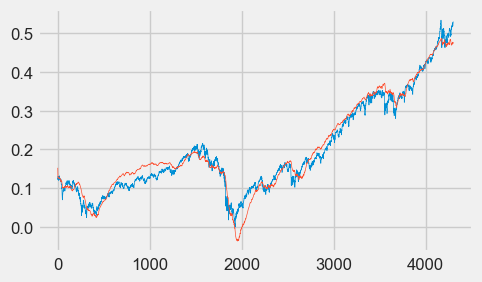

In [15]:
import matplotlib.pyplot as plt
fig1, axes1 = plt.subplots(figsize = (5, 3))
axes1.plot(whole_y_arr, linewidth=0.5)
axes1.plot(whole_pred_arr, linewidth=0.5)
fig1.savefig("model_evolve.pdf")

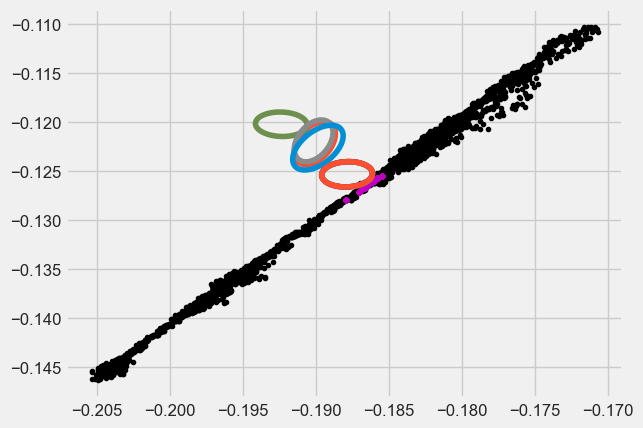

In [16]:
from importlib import reload 
import compute_ellipse
reload(compute_ellipse)
from numpy.linalg import inv

sigma_inv = model.evolve.sigma_inv
sigma_inv = torch.matmul(sigma_inv, torch.transpose(sigma_inv, 2, 1))
sigma = inv(sigma_inv.detach().cpu().numpy())

nc_plot = num_clusters
sigma = sigma[0:nc_plot,0:2,0:2]
mu = model.evolve.mu.detach().cpu().numpy()
mu = mu[0:nc_plot,0:2]

ellipse = compute_ellipse.Ellipse(sigma,mu,1)
ellipse_points = ellipse.confidence_ellipse()
ellipse_points = np.einsum('ijk->jik', ellipse_points)
plt.plot(x_ant[:,0,0],x_ant[:,0,1],'.k')
plt.plot(x_ant_train[:,0,0],x_ant_train[:,0,1],'.m')
plt.plot(ellipse_points[:,:,0],ellipse_points[:,:,1])
plt.show()  


In [17]:
history -g


 1/1: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 1/2: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 2/1: !python tools/test.py configs/swin/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood.py work_dirs/mask_rcnn_swin_tiny_patch4_window7_mstrain_480-800_adamw_1x_coco_wood/latest.pth --show-dir results_wood/inference --out results_wood/results.pkl --eval bbox --options "jsonfile_prefix=results_wood"
 3/1: !python tools/test.py con

In [18]:
'''
%matplotlib inline
import time
import pylab as pl
from IPython import display
#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)
#line1, = axes2.plot(np.zeros(output_length))
#line2, = axes2.plot(np.zeros(output_length))

import matplotlib.pyplot as plt
import time

def simulate(dataloader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn, cn = model.init()
        for batch, item in enumerate(dataloader):
            x, y = item
            x, y = x.to(device), y.to(device)
            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]
            pred = pred.detach().cpu().numpy().reshape(-1,1)
            #pred = pred.view(1, output_length)
            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)
            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)
            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)
            #y = scalar.inverse_transform(y)[:,0].reshape(-1)
            y = y.detach().cpu().numpy().reshape(-1,1)
            pred_arr = np.append( pred_arr, pred)
            y_arr = np.append(y_arr, y)

            
            #axes2.cla()  
            #line1.set_ydata(pred_arr)
            #line2.set_ydata(y_arr)
            plt.plot(pred_arr,'b')
            plt.plot(y_arr,'r')
            #fig2.tight_layout()
            #fig2.show()

            display.display(pl.gcf())   
            display.clear_output(wait=True)
            time.sleep(0.1)
            
    return pred_arr, y_arr

batch_size = 1
whole_pred_arr, whole_y_arr = simulate(whole_dataloader)
'''

"\n%matplotlib inline\nimport time\nimport pylab as pl\nfrom IPython import display\n#fig2, axes2 = plt.subplots(figsize = (5, 3), linewidth=0.5)\n#line1, = axes2.plot(np.zeros(output_length))\n#line2, = axes2.plot(np.zeros(output_length))\n\nimport matplotlib.pyplot as plt\nimport time\n\ndef simulate(dataloader):\n    pred_arr = []\n    y_arr = []\n    with torch.no_grad():\n        hn, cn = model.init()\n        for batch, item in enumerate(dataloader):\n            x, y = item\n            x, y = x.to(device), y.to(device)\n            pred,hn,cn = model(x.reshape(input_length, batch_size, input_dim), hn, cn) #[0]\n            pred = pred.detach().cpu().numpy().reshape(-1,1)\n            #pred = pred.view(1, output_length)\n            #pred = np.repeat(pred.detach().cpu().numpy(),input_dim,axis=1)\n            #pred = scalar.inverse_transform(pred)[:,0].reshape(-1)\n            #y = np.repeat(y.detach().cpu().numpy().reshape(-1,1),input_dim,axis=1)\n            #y = scalar.inverse